# Exploratory Data Analysis

Hypothesis testing and charting related to job satisfaction using Stack Overflow Developer Survey data from 2019.

In [1]:
import sqlite3

import matplotlib
import pandas
import scipy.stats

%matplotlib inline

In [2]:
conn = sqlite3.connect('source_data.sqlite')

**Hypothesis 1: Some dev types are more satisfied than others. (accepted)**

In [3]:
dev_type_satisfaction_summary = pandas.read_csv('dev_type_satisfaction_summary.csv')

In [4]:
dev_type_satisfaction_summary['satisfiedRatio'] = dev_type_satisfaction_summary.apply(
    lambda x: x['satisfiedCount'] / x['dissatisfiedCount'],
    axis=1
)

Text(0, 0.5, '')

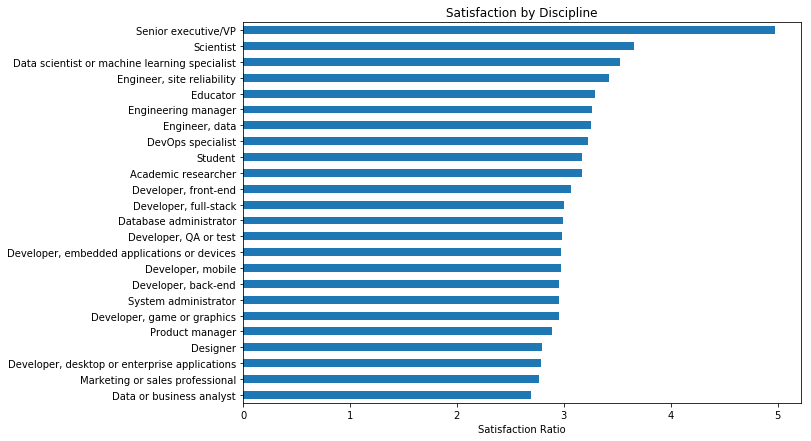

In [5]:
ax = dev_type_satisfaction_summary.sort_values('satisfiedRatio').plot.barh(
    x='devType',
    y='satisfiedRatio',
    title='Satisfaction by Discipline',
    figsize=(10,7)
)

ax.get_legend().remove()
ax.set_xlabel('Satisfaction Ratio')
ax.set_ylabel('')

In [6]:
scipy.stats.chi2_contingency(dev_type_satisfaction_summary[['satisfiedCount', 'dissatisfiedCount']].transpose().as_matrix())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(128.01761369413111,
 1.470992820599018e-16,
 23,
 array([[ 2158.68022569,  2742.69642881,  2817.85938931,  4389.51689346,
          3561.97269831,  4703.69806837,  3090.70093594, 19025.24856289,
          7922.92766678,  3209.45841354, 12162.87026884, 20427.0377763 ,
          1624.2715765 ,  6311.43379356,  1859.53164288,  2702.10843014,
          1467.18098905,  2034.66134086,   299.90021241,  1812.17897776,
          1491.98476601,   924.50441421,  2504.42984401,  3988.14668437],
        [  713.31977431,   906.30357119,   931.14061069,  1450.48310654,
          1177.02730169,  1554.30193163,  1021.29906406,  6286.75143711,
          2618.07233322,  1060.54158646,  4019.12973116,  6749.9622237 ,
           536.7284235 ,  2085.56620644,   614.46835712,   892.89156986,
           484.81901095,   672.33865914,    99.09978759,   598.82102224,
           493.01523399,   305.49558579,   827.57015599,  1317.85331563]]))

**Hypothesis 2: Some job factors are more prevelant in some dev types than others (accepted).**

In [7]:
job_factor_counts = pandas.read_csv('job_factor_counts.csv')

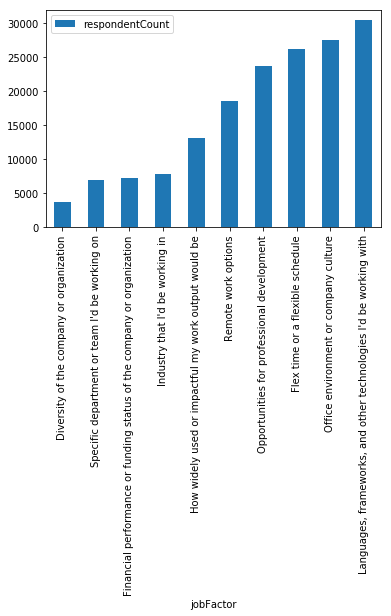

In [8]:
job_factor_counts.sort_values('respondentCount').plot.bar(x='jobFactor', y='respondentCount')

In [9]:
job_factor_to_dev_type = pandas.read_csv('job_factor_to_dev_type_jaccard.csv')

In [10]:
dev_types = job_factor_to_dev_type['devType'].unique()
job_factors = job_factor_to_dev_type['jobFactor'].unique()

In [11]:
def get_val(target_slice, default_val):
    try:
        return target_slice.iloc[0]
    except IndexError:
        return default_val


def get_factors_for_type(dev_type):
    for_dev_type = job_factor_to_dev_type[job_factor_to_dev_type['devType'] == dev_type]
    values = list(map(
        lambda x: get_val(for_dev_type[for_dev_type['jobFactor'] == x]['overlapCount'], 0),
        job_factors
    ))
    return values


dev_factor_contingency = map(get_factors_for_type, dev_types)
dev_factor_contingency = filter(lambda x: not 0 in x, dev_factor_contingency)
dev_factor_contingency = list(dev_factor_contingency)

In [12]:
scipy.stats.chi2_contingency(dev_factor_contingency)

(3598.3832468080413,
 0.0,
 207,
 array([[  204.9099963 ,   427.13848893,  1552.30433625,   796.61251555,
           454.53389793,  1760.39449891,  1564.2970118 ,  1366.78186016,
          1118.07752471,   395.94986945],
        [  259.0864905 ,   540.07034333,  1962.72065749,  1007.2302214 ,
           574.70887002,  2225.82812382,  1977.88409645,  1728.14758587,
          1413.68789817,   500.63571295],
        [  265.86652254,   554.20343927,  2014.08307667,  1033.58841998,
           589.74842125,  2284.07579991,  2029.64332752,  1773.37146445,
          1450.68268402,   513.73684441],
        [  415.72860986,   866.59359439,  3149.36965222,  1616.19549882,
           922.17436403,  3571.55029548,  3173.70081431,  2772.97512549,
          2268.39501953,   803.31702587],
        [  336.25983316,   700.93953255,  2547.35057606,  1307.2509707 ,
           745.89573688,  2888.82910147,  2567.03070467,  2242.90590288,
          1834.77901861,   649.75862302],
        [  438.53417215,   

**Hypothesis 3: Compensation and satisfaction are related (accepted).**

In [13]:
comp_satisfaction = pandas.read_sql(
    '''
    SELECT
      respondentId,
      compensation + 0.0 AS compensation,
      (
        CASE
          WHEN lower(jobSatisfaction) like '%neither%' THEN 0
          WHEN lower(jobSatisfaction) like '%dissatisfied%' THEN 1
          ELSE 0
        END
      ) AS isDissatisfied,
      (
        CASE
          WHEN lower(jobSatisfaction) like '%neither%' THEN 0
          WHEN lower(jobSatisfaction) like '%dissatisfied%'
          THEN 0
          ELSE 1
        END
      ) AS isSatisfied
    FROM
      source_data
    GROUP BY
        respondentId
    ''',
    conn
)

In [14]:
comp_satisfaction_satisfied = comp_satisfaction[comp_satisfaction['isSatisfied'] == 1]
comp_satisfaction_dissatisfied = comp_satisfaction[comp_satisfaction['isDissatisfied'] == 1]

In [15]:
scipy.stats.mannwhitneyu(comp_satisfaction_satisfied['compensation'], comp_satisfaction_dissatisfied['compensation'])

MannwhitneyuResult(statistic=199124986.0, pvalue=1.7577801970432773e-116)

In [16]:
comp_satisfaction_satisfied['compensation'].mean()

135255.04410297883

In [17]:
comp_satisfaction_dissatisfied['compensation'].mean()

113558.5780081987

In [18]:
comp_satisfaction_satisfied['compensation'].mean() - comp_satisfaction_dissatisfied['compensation'].mean()

21696.46609478013